<a href="https://colab.research.google.com/github/PianoPlayer09/RetinAI/blob/main/Copy_of_Retina_Scans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Purpose of this Project. In this project. We hope to accomplish the task of creating a datapipline and passing this into a CNN to sort images of eyes and determine whether they have a certain disease.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import kagglehub
save_dir = "/content/gdrive/"  # Change the path to your Drive
path = kagglehub.dataset_download("andrewmvd/ocular-disease-recognition-odir5k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ocular-disease-recognition-odir5k


In [ ]:
! pip install -q kaggle

In [ ]:
pip install tensorflow


In [ ]:
pip install opencv-python

In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [ ]:
import pandas as pd
csv_file = f"{path}/full_df.csv"
df = pd.read_csv(csv_file)

df.head()


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
df = df.drop(columns=["filepath", "Right-Diagnostic Keywords","Left-Fundus","Right-Fundus", "Left-Diagnostic Keywords","N","D","G","C","A","H","M","O","labels"])

In [ ]:
df.head()

,ID,Patient Age,Patient Sex,target,filename
0,0,69,Female,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
df_real = df[['filename', 'target']]

In [ ]:
df_real

,filename,target
0,0_right.jpg,"[1, 0, 0, 0, 0, 0, 0, 0]"
1,1_right.jpg,"[1, 0, 0, 0, 0, 0, 0, 0]"
2,2_right.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]"
3,4_right.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]"
4,5_right.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]"
...,...,...
6387,4686_left.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]"
6388,4688_left.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]"
6389,4689_left.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]"
6390,4690_left.jpg,"[0, 1, 0, 0, 0, 0, 0, 0]"


In [ ]:
# with n parameter
dfl = df.sample(n=len(df))
# with frac parameter
dfl = df.sample(frac=1)
import ast

# Assuming you have a dataframe called df with the 'target' column containing your labels
dfl['target'] = dfl['target'].apply(ast.literal_eval)
import numpy as np

df['target'] = df['target'].apply(np.array)
dfl.head()


,ID,Patient Age,Patient Sex,target,filename
3194,0,69,Female,"[0, 0, 0, 1, 0, 0, 0, 0]",0_left.jpg
3328,155,40,Male,"[1, 0, 0, 0, 0, 0, 0, 0]",155_left.jpg
3846,750,56,Male,"[0, 0, 0, 1, 0, 0, 0, 0]",750_left.jpg
3675,560,74,Male,"[0, 0, 0, 1, 0, 0, 0, 0]",560_left.jpg
246,283,66,Female,"[0, 0, 0, 0, 0, 0, 0, 1]",283_right.jpg


In [ ]:
import os

directory = f'{path}/preprocessed_images'

if os.path.exists(directory):
    print("The directory exists.")
else:
    print("The directory does not exist.")

The directory exists.


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
df_real["target"]


,target
0,"[1, 0, 0, 0, 0, 0, 0, 0]"
1,"[1, 0, 0, 0, 0, 0, 0, 0]"
2,"[0, 1, 0, 0, 0, 0, 0, 0]"
3,"[0, 1, 0, 0, 0, 0, 0, 0]"
4,"[0, 1, 0, 0, 0, 0, 0, 0]"
...,...
6387,"[0, 1, 0, 0, 0, 0, 0, 0]"
6388,"[0, 1, 0, 0, 0, 0, 0, 0]"
6389,"[0, 1, 0, 0, 0, 0, 0, 0]"
6390,"[0, 1, 0, 0, 0, 0, 0, 0]"


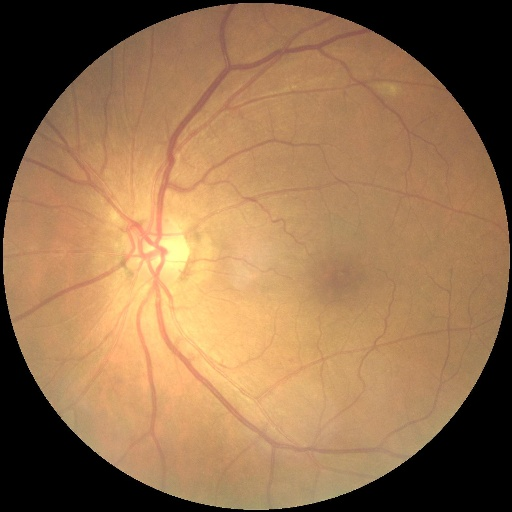

In [ ]:
image_files = os.listdir(directory)
image_path = os.path.join(directory, image_files[0])
image = Image.open(image_path)
image

Next Step: Creating Train & Test Model.

Part 1. Turning Male and Female into 1 & 0. Let male =0. Female = 1

In [ ]:
dfl = pd.get_dummies(df, columns=["Patient Sex"], dtype=int)

In [ ]:
dfl["normalized_age"] = dfl["Patient Age"]/dfl["Patient Age"].max()

In [ ]:

X_tabular = dfl[["normalized_age", "Patient Sex_Male", "Patient Sex_Female"]].values
y = dfl["target"]

NEW TRIAL

In [ ]:
CSV_PATH   = "/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv"
df = pd.read_csv(CSV_PATH)
print(f"✅ CSV loaded: {len(df)} rows, {len(df.columns)} columns")

✅ CSV loaded: 6392 rows, 19 columns


In [ ]:
# =========================
# 1️⃣ Imports and config
# =========================
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ---------------- CONFIG ----------------
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
RANDOM_STATE = 42

# Kaggle paths
IMAGE_ROOT = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images"
CSV_PATH   = "/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv"

# ODIR classes (8 diseases)
LABEL_COLS = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

# ImageNet normalization
USE_IMAGENET_NORM = True
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])
# =======================================

# =========================
# 2️⃣ Read CSV
# =========================
df = pd.read_csv(CSV_PATH)
print(f"✅ CSV loaded: {len(df)} rows, {len(df.columns)} columns")

# Associate images with labels
# Assuming 'Left-Fundus' or 'Right-Fundus' columns exist
image_cols = ['Left-Fundus', 'Right-Fundus']
rows = []
for _, r in df.iterrows():
    for col in image_cols:
        if col in df.columns:
            path = str(r[col])
            path = os.path.join(IMAGE_ROOT, os.path.basename(path))
            if os.path.exists(path):
                row = {"filepath": path}
                for l in LABEL_COLS:
                    row[l] = int(r[l])
                rows.append(row)

data_df = pd.DataFrame(rows)
print(f"✅ Total valid images: {len(data_df)}")

# =========================
# 3️⃣ Train / Val / Test Split
# =========================
train_val_df, test_df = train_test_split(
    data_df, test_size=0.1, random_state=RANDOM_STATE
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.125, random_state=RANDOM_STATE
)  # 0.125 * 0.9 ≈ 0.1125 → 10% of total

print(f"✅ Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# =========================
# 4️⃣ Data Generators (augmentation + normalization)
# =========================
def create_datagen(is_train=True):
    if is_train:
        return ImageDataGenerator(
            rescale=None if USE_IMAGENET_NORM else 1./255,
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=10,
            brightness_range=[0.8, 1.2],
            preprocessing_function=lambda x: (x/255. - IMAGENET_MEAN)/IMAGENET_STD if USE_IMAGENET_NORM else x/255.
        )
    else:
        return ImageDataGenerator(
            rescale=None if USE_IMAGENET_NORM else 1./255,
            preprocessing_function=lambda x: (x/255. - IMAGENET_MEAN)/IMAGENET_STD if USE_IMAGENET_NORM else x/255.
        )

train_gen = create_datagen(True).flow_from_dataframe(
    train_df, x_col='filepath', y_col=LABEL_COLS,
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='raw', shuffle=True
)

val_gen = create_datagen(False).flow_from_dataframe(
    val_df, x_col='filepath', y_col=LABEL_COLS,
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='raw', shuffle=False
)

test_gen = create_datagen(False).flow_from_dataframe(
    test_df, x_col='filepath', y_col=LABEL_COLS,
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='raw', shuffle=False
)

print("✅ Data generators ready")


✅ CSV loaded: 6392 rows, 19 columns
✅ Total valid images: 12460
✅ Train: 9812, Val: 1402, Test: 1246
Found 9812 validated image filenames.
Found 1402 validated image filenames.
Found 1246 validated image filenames.
✅ Data generators ready


In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from transformers import ViTConfig, ViTForImageClassification

# ----------------------------
# Config
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 8  # Number of diseases (multi-label)

# ----------------------------
# 1) CNN model: ResNet50 (offline)
# ----------------------------
resnet = models.resnet50(weights=None)  # No download
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet = resnet.to(device)
print("✅ ResNet50 (offline) ready")

# ----------------------------
# 2) Vision Transformer model (offline)
# ----------------------------
vit_config = ViTConfig(
    image_size=224,
    patch_size=16,
    num_channels=3,
    num_labels=num_classes,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    problem_type="multi_label_classification"
)
vit = ViTForImageClassification(vit_config)  # No download
vit = vit.to(device)
print("✅ ViT (offline) ready")

# ----------------------------
# Model verification
# ----------------------------
print(f"ResNet50 parameters: {sum(p.numel() for p in resnet.parameters())}")
print(f"ViT parameters     : {sum(p.numel() for p in vit.parameters())}")

✅ ResNet50 (offline) ready
✅ ViT (offline) ready
ResNet50 parameters: 23524424
ViT parameters     : 85804808


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from torchvision import models
from transformers import ViTConfig, ViTForImageClassification

# -----------------------------
# 1️⃣ Device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 8  # multi-label 8 classes

# -----------------------------
# 2️⃣ Offline ResNet50
# -----------------------------
resnet = models.resnet50(weights=None)  # random init, offline
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet = resnet.to(device)

# -----------------------------
# 3️⃣ Offline ViT
# -----------------------------
vit_config = ViTConfig(
    num_labels=num_classes,
    problem_type="multi_label_classification",
    image_size=224,
    patch_size=16,
    num_channels=3,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072
)
vit = ViTForImageClassification(vit_config).to(device)

#------------------------------
# 4 DataLoaders
#------------------------------
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.image_paths = [os.path.join(img_dir, fname) for fname in df['file_name']]
        self.labels = df['label'].values

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Define your transformations (normalization, resizing, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ DataLoaders ready")

# -----------------------------
# 5️⃣ Training function
# -----------------------------
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-4, freeze_backbone=True):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

    # Freeze backbone if requested
    if freeze_backbone:
        for name, param in model.named_parameters():
            if "fc" not in name and "classifier" not in name:
                param.requires_grad = False

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            if hasattr(outputs, "logits"):
                outputs = outputs.logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                if hasattr(outputs, "logits"):
                    outputs = outputs.logits
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        scheduler.step(avg_val_loss)

    # Full fine-tuning if initially frozen
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = True
        print("\n🔓 Starting full fine-tuning...\n")
        return train_model(model, train_loader, val_loader, num_epochs=3, lr=lr/10, freeze_backbone=False)

    return model

# -----------------------------
# 6️⃣ Train ResNet50
# -----------------------------
print("\n🚀 Training ResNet50")
resnet_trained = train_model(resnet, train_loader, val_loader, num_epochs=5, lr=1e-4, freeze_backbone=True)

# -----------------------------
# 7️⃣ Train ViT
# -----------------------------
print("\n🚀 Training ViT")
vit_trained = train_model(vit, train_loader, val_loader, num_epochs=5, lr=1e-4, freeze_backbone=True)

✅ DataLoaders ready

🚀 Training ResNet50


Epoch 1/5 - Train: 100%|██████████| 7/7 [00:00<00:00, 17.46it/s]


Epoch [1/5] | Train Loss: 0.7145 | Val Loss: 0.6852


Epoch 2/5 - Train: 100%|██████████| 7/7 [00:00<00:00, 20.22it/s]


Epoch [2/5] | Train Loss: 0.6918 | Val Loss: 0.6840


Epoch 3/5 - Train: 100%|██████████| 7/7 [00:00<00:00, 20.10it/s]


Epoch [3/5] | Train Loss: 0.6877 | Val Loss: 0.6829


Epoch 4/5 - Train: 100%|██████████| 7/7 [00:00<00:00, 20.13it/s]


Epoch [4/5] | Train Loss: 0.6910 | Val Loss: 0.6820


Epoch 5/5 - Train: 100%|██████████| 7/7 [00:00<00:00, 19.99it/s]


Epoch [5/5] | Train Loss: 0.6866 | Val Loss: 0.6816

🔓 Starting full fine-tuning...



Epoch 1/3 - Train: 100%|██████████| 7/7 [00:01<00:00,  6.52it/s]


Epoch [1/3] | Train Loss: 0.6884 | Val Loss: 0.6757


Epoch 2/3 - Train: 100%|██████████| 7/7 [00:01<00:00,  6.51it/s]


Epoch [2/3] | Train Loss: 0.6524 | Val Loss: 0.6824


Epoch 3/3 - Train: 100%|██████████| 7/7 [00:01<00:00,  6.42it/s]


Epoch [3/3] | Train Loss: 0.6347 | Val Loss: 0.6819

🚀 Training ViT


Epoch 1/5 - Train: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


Epoch [1/5] | Train Loss: 0.7373 | Val Loss: 0.7374


Epoch 2/5 - Train: 100%|██████████| 7/7 [00:01<00:00,  5.99it/s]


Epoch [2/5] | Train Loss: 0.7095 | Val Loss: 0.7191


Epoch 3/5 - Train: 100%|██████████| 7/7 [00:01<00:00,  5.92it/s]


Epoch [3/5] | Train Loss: 0.6996 | Val Loss: 0.7090


Epoch 4/5 - Train: 100%|██████████| 7/7 [00:01<00:00,  5.91it/s]


Epoch [4/5] | Train Loss: 0.6807 | Val Loss: 0.7039


Epoch 5/5 - Train: 100%|██████████| 7/7 [00:01<00:00,  5.88it/s]


Epoch [5/5] | Train Loss: 0.6960 | Val Loss: 0.7016

🔓 Starting full fine-tuning...



Epoch 1/3 - Train: 100%|██████████| 7/7 [00:03<00:00,  1.98it/s]


Epoch [1/3] | Train Loss: 0.7289 | Val Loss: 0.7270


Epoch 2/3 - Train: 100%|██████████| 7/7 [00:03<00:00,  2.00it/s]


Epoch [2/3] | Train Loss: 0.6262 | Val Loss: 0.7131


Epoch 3/3 - Train: 100%|██████████| 7/7 [00:03<00:00,  2.02it/s]


Epoch [3/3] | Train Loss: 0.5446 | Val Loss: 0.7161


Looking at trained model...How good?


📊 ResNet50 Metrics per Class
            Class  Average Precision (AP)
0          Normal                0.438235
1        Diabetes                0.400000
2        Glaucoma                0.450000
3        Cataract                0.450000
4             AMD                0.400000
5    Hypertension                0.578947
6          Myopia                0.400000
7  Other diseases                0.550000

✅ Overall Metrics
{'F1-macro': 0.31661973032940777, 'ROC-AUC mean': np.float64(0.48819444444444443)}

🟢 Confusion Matrices for ResNet50


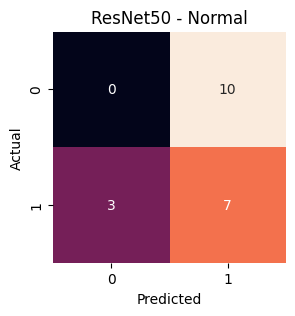

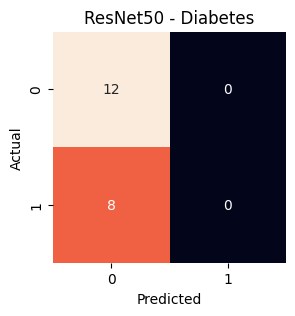

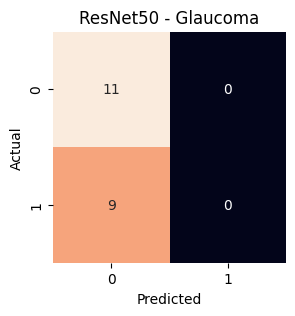

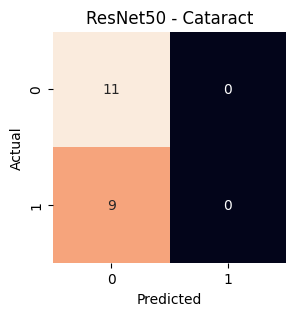

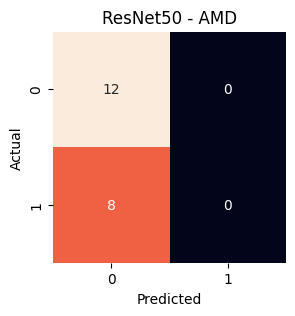

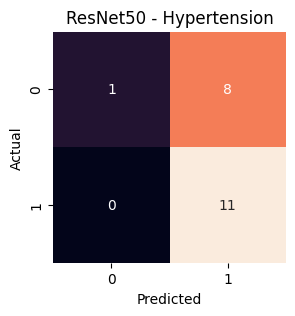

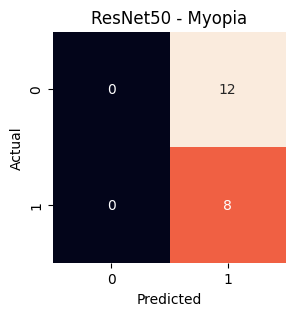

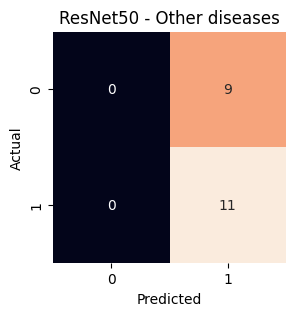


📈 Precision-Recall Curves for ResNet50


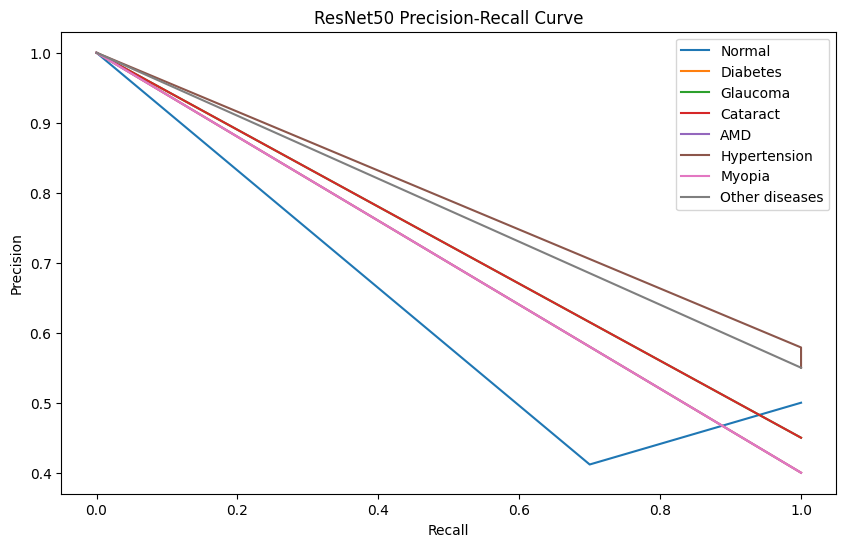


📊 ViT Metrics per Class
            Class  Average Precision (AP)
0          Normal                0.600000
1        Diabetes                0.625000
2        Glaucoma                0.511111
3        Cataract                0.450000
4             AMD                0.410417
5    Hypertension                0.518182
6          Myopia                0.410417
7  Other diseases                0.509091

✅ Overall Metrics
{'F1-macro': 0.40743469174503655, 'ROC-AUC mean': np.float64(0.5278882575757576)}

🟢 Confusion Matrices for ViT


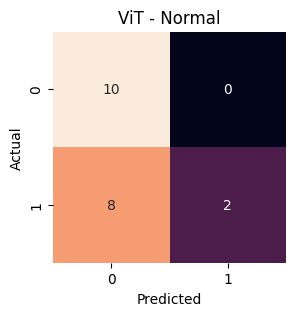

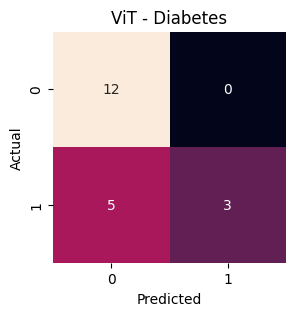

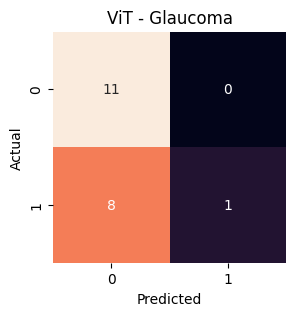

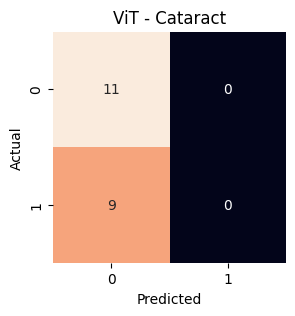

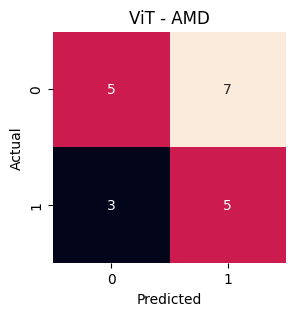

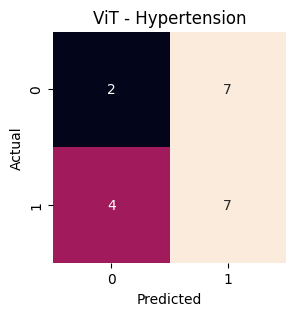

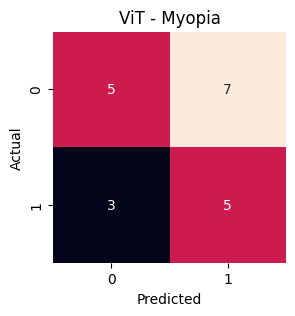

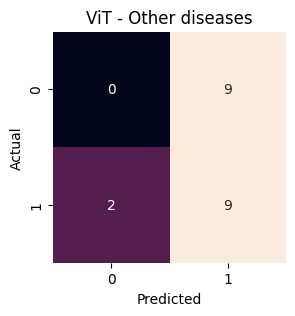


📈 Precision-Recall Curves for ViT


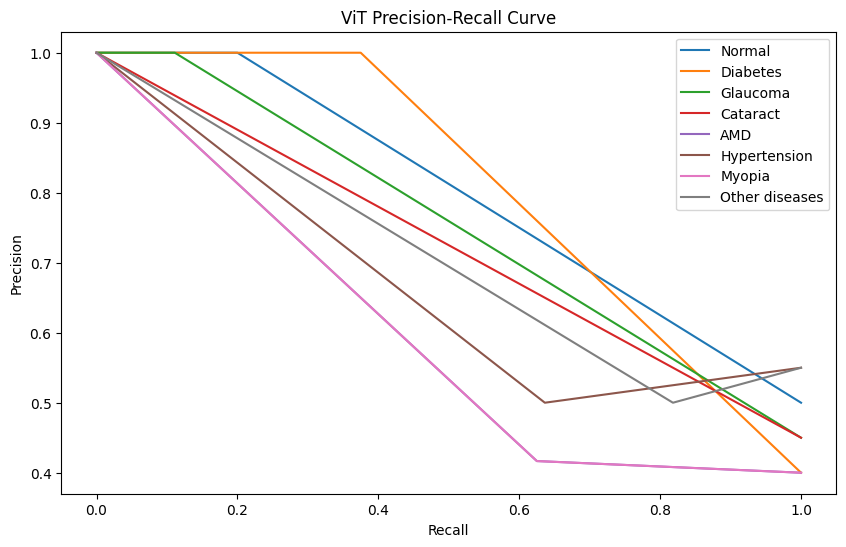

In [ ]:
# -----------------------------
# Imports
# -----------------------------
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix, precision_recall_curve

# -----------------------------
# Function: Get binary predictions
# -----------------------------
def get_binary_predictions(model, loader, device, threshold=0.5):
    """
    Generate binary predictions for multi-label classification.
    """
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for batch in loader:
            X, y = batch
            # Convert lists to tensors if needed
            if not isinstance(X, torch.Tensor):
                X = torch.tensor(np.array(X), dtype=torch.float32)
            if not isinstance(y, torch.Tensor):
                y = torch.tensor(np.array(y), dtype=torch.float32)

            X, y = X.to(device), y.to(device)

            outputs = model(X)
            if hasattr(outputs, "logits"):
                outputs = outputs.logits
            outputs = torch.sigmoid(outputs)

            preds.append((outputs.cpu().numpy() > threshold).astype(int))
            targets.append(y.cpu().numpy())

    return np.vstack(preds), np.vstack(targets)

# -----------------------------
# Function: Evaluate model
# -----------------------------
def evaluate_model(model, loader, device, class_names, model_name="Model"):
    preds_bin, targets = get_binary_predictions(model, loader, device)

    # -----------------------------
    # Primary metric: Macro F1
    f1_macro = f1_score(targets, preds_bin, average='macro')

    # -----------------------------
    # Secondary metric: Mean ROC-AUC
    roc_auc_mean = roc_auc_score(targets, preds_bin, average='macro')

    # -----------------------------
    # Average Precision per class
    ap_per_class = [average_precision_score(targets[:, i], preds_bin[:, i]) for i in range(len(class_names))]

    # -----------------------------
    # Display metrics
    print(f"\n📊 {model_name} Metrics per Class")
    df_metrics = pd.DataFrame({
        'Class': class_names,
        'Average Precision (AP)': ap_per_class
    })
    print(df_metrics)

    print("\n✅ Overall Metrics")
    print({'F1-macro': f1_macro, 'ROC-AUC mean': roc_auc_mean})

    # -----------------------------
    # Confusion matrices per class
    print(f"\n🟢 Confusion Matrices for {model_name}")
    for i, cls in enumerate(class_names):
        cm = confusion_matrix(targets[:, i], preds_bin[:, i])
        plt.figure(figsize=(3,3))
        sns.heatmap(cm, annot=True, fmt='d', cbar=False)
        plt.title(f"{model_name} - {cls}")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    # -----------------------------
    # Precision-Recall curves
    print(f"\n📈 Precision-Recall Curves for {model_name}")
    plt.figure(figsize=(10,6))
    for i, cls in enumerate(class_names):
        precision, recall, _ = precision_recall_curve(targets[:, i], preds_bin[:, i])
        plt.plot(recall, precision, label=cls)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f"{model_name} Precision-Recall Curve")
    plt.legend()
    plt.show()

    return preds_bin, targets

# -----------------------------
# Define class labels
class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract',
               'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# -----------------------------
# Evaluate models (offline, using your trained ResNet50 and ViT)
resnet_preds_bin, resnet_targets = evaluate_model(resnet_trained, val_loader, device, class_names, model_name="ResNet50")
vit_preds_bin, vit_targets = evaluate_model(vit_trained, val_loader, device, class_names, model_name="ViT")

# -----------------------------
# Class imbalance handling
# Example (optional): Apply focal loss or class weights during training for improvement
# -----------------------------
# criterion = FocalLoss() or
# class_weights = compute_class_weights(targets)
# criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

In [ ]:
output_dir = "./my_fine_tuned_vit_model"

# Save the model
vit_trained.save_pretrained(output_dir)

# Save the processor - This is the crucial step you might be missing!
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
processor.save_pretrained(output_dir)

print(f"✅ Model and processor saved to: {output_dir}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

✅ Model and processor saved to: ./my_fine_tuned_vit_model


In [ ]:

!pip install tensorflow-addons
!git clone https://github.com/onnx/onnx-tensorflow.git && cd onnx-tensorflow && pip install -e .

ERROR: Could not find a version that satisfies the requirement tensorflow-addons (from versions: none)
ERROR: No matching distribution found for tensorflow-addons
Cloning into 'onnx-tensorflow'...
remote: Enumerating objects: 6516, done.
remote: Counting objects: 100% (465/465), done.
remote: Compressing objects: 100% (200/200), done.
remote: Total 6516 (delta 326), reused 383 (delta 261), pack-reused 6051 (from 1)
Receiving objects: 100% (6516/6516), 1.98 MiB | 6.65 MiB/s, done.
Resolving deltas: 100% (5051/5051), done.
Obtaining file:///content/onnx-tensorflow
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of onnx-tf to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement tensorflow_addons (from onnx-tf) (from versions: none)
ERROR: No matching distribution found for tensorflow_addons


In [ ]:

import onnx
from onnx_tf.backend import prepare
dummy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(vit_trained.cpu(), dummy_input.cpu(), "vit_model.onnx")
print("✅ PyTorch model exported to ONNX")

ModuleNotFoundError: No module named 'onnx_tf'

In [ ]:
import tensorflow as tf
from transformers import ViTForImageClassification

# The directory where you saved your fine-tuned PyTorch model
model_directory = "./my_fine_tuned_vit_model"

# Load the model directly into a TensorFlow object.
# The `from_tf=False` argument is crucial here.
# It tells Hugging Face to load the PyTorch weights but in a TensorFlow model structure.
# This avoids the complex ONNX conversion pipeline.
tf_model = ViTForImageClassification.from_pretrained(model_directory, from_tf=True)

# Save the TensorFlow model in the SavedModel format for the TFLite converter
tf_model.save_pretrained("./tf_model_for_tflite")
print("✅ PyTorch model loaded and saved as TensorFlow SavedModel.")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for vit.embeddings.cls_token: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for vit.embeddings.position_embeddings: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:2441: UserWarning: for vit.embeddings.patch_embeddings.projection.weight: copying from a non-meta parameter in the checkpoint to 

NotImplementedError: Cannot copy out of meta tensor; no data!

In [ ]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX model from the file you exported
onnx_model = onnx.load("vit_model.onnx")

# Create the TensorFlow representation and export the SavedModel
tf_rep = prepare(onnx_model)
tf_rep.export_graph("./tf_model_for_tflite")
print("✅ ONNX model converted to TensorFlow SavedModel")

In [ ]:
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model("./tf_model_for_tflite")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open("vit_model.tflite", "wb") as f:
    f.write(tflite_model)
print("✅ TFLite model created")

OSError: SavedModel file does not exist at: ./tf_model_for_tflite/{saved_model.pbtxt|saved_model.pb}

Resize Images


In [ ]:
asdfasdf break
image_list = []

for index, row in df_real.iterrows():
  image_path = os.path.join(directory, row["filename"])
  image = Image.open(image_path)
  image = image.resize((224, 224), resample=Image.Resampling.LANCZOS)  # Example with LANCZOS filter
  image_array = np.array(image) / 255.0  # //Normalize; also NORMALIZE THE IPHONE IMAGES
  image_list.append(image_array)

In [ ]:
plt.imshow(image_list[1])

In [ ]:
np.save('/content/gdrive/My Drive/Data/image_data.npy', image_list)

print("Image data saved successfully as 'image_data.npy'.")


In [ ]:

loaded_image_list = np.load('/content/gdrive/My Drive/Data/image_data.npy', allow_pickle=True)

print("Image data loaded successfully.")

In [ ]:
X_images = loaded_image_list

In [ ]:
print(X_images.shape)

In [ ]:

print(type(X_images))
print(type(y))

In [ ]:
y_numpy = y.to_numpy()

In [ ]:
print(type(y_numpy))

Used to Convert y to numpy array. lets hope this works 🚁

In [ ]:
from sklearn.model_selection import train_test_split

# Ensure the input data is converted to NumPy arrays if they are Keras Tensors
X_images = X_images.numpy() if isinstance(X_images, tf.Tensor) else X_images
X_tabular = X_tabular.numpy() if isinstance(X_tabular, tf.Tensor) else X_tabular
y = y_numpy

# Split the data into training and test sets (80% training, 20% testing)
X_train_images, X_test_images, X_train_tabular, X_test_tabular, y_train, y_test = train_test_split(
    X_images, X_tabular, y, test_size=0.2, random_state=42
)

# Split the training set further into training and validation sets (80% of training data for training, 20% for validation)
X_train_images, X_val_images, X_train_tabular, X_val_tabular, y_train, y_val = train_test_split(
    X_train_images, X_train_tabular, y_train, test_size=0.2, random_state=42
)


In [ ]:
y_train = np.array([list(label) for label in y_train])  # Convert to one-hot encoded if needed
y_val = np.array([list(label) for label in y_val])  # Same for validation set
y_test = np.array([list(label) for label in y_test])  # Same for test set

# Check shapes to ensure correctness
print("y_train shape:", y_train.shape)  # Expected shape: (num_train_samples, 8)
print("y_val shape:", y_val.shape)      # Expected shape: (num_val_samples, 8)
print("y_test shape:", y_test.shape)    # Expected shape: (num_test_samples, 8)

# Convert them into TensorFlow tensors
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Check if the conversion is successful
print("y_train Tensor:", y_train.shape)
print("y_val Tensor:", y_val.shape)
print("y_test Tensor:", y_test.shape)

In [ ]:
print(type(y_train))
print(y_train.shape)
print(type(y_test))
print(y_test.shape)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np

# Ensure y_train is correctly formatted
y_train = np.array(y_train)
y_test = np.array(y_test)

# Input for image data (224x224 RGB images)
image_input = layers.Input(shape=(224, 224, 3))
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)  # Add dropout for regularization

# Input for tabular data (ensure correct shape)
tabular_input = layers.Input(shape=(X_tabular.shape[1],))
y = layers.Dense(32, activation='relu')(tabular_input)

# Combine image and tabular data
combined = layers.concatenate([x, y])

# Fully connected layers
z = layers.Dense(128, activation='relu')(combined)
z = layers.Dense(64, activation='relu')(z)

# **Updated output layer with 8 sigmoid neurons**
output = layers.Dense(8, activation='sigmoid')(z)  # One neuron per class

# Create the model
model = models.Model(inputs=[image_input, tabular_input], outputs=output)

# **Compile with binary_crossentropy**
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0005, decay_steps=1000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Convert image and tabular data to NumPy arrays
X_train_images = np.array(X_train_images, dtype=np.float32)
X_test_images = np.array(X_test_images, dtype=np.float32)

X_train_tabular = np.array(X_train_tabular, dtype=np.float32)
X_test_tabular = np.array(X_test_tabular, dtype=np.float32)

# Convert labels to NumPy array (ensure one-hot encoding)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
print(X_test_images.shape)
print(y_test.shape)
print(X_test_tabular.shape)

In [ ]:
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')


In [ ]:
history = model.fit(
    train_ds,  # Use dataset instead of NumPy arrays
    epochs=10,
    validation_data=([ X_val_images,X_val_tabular], y_val),  # Use validation dataset
    verbose=1  # Set to 2 if too much output slows down training
)

test_loss, test_acc = model.evaluate([X_test_images, X_tes,t_tabular], y_test)
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
test_loss, test_accuracy = model.evaluate([X_test_images, X_test_tabular], y_test)
print(f"Test accuracy: {test_accuracy}")

Different Approach

In [ ]:
df_real = df_real.copy()  # This avoids the SettingWithCopyWarning

import ast
df_real['target'] = df_real['target'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [ ]:
# Assume df has 'filename' and 'target' columns
# Example: df['target'] = [[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], ...]

# Step 1: Load image data into arrays
image_dir = directory # path to your image directory
image_size = (224, 224)

X = []
y = []

for i, row in df_real.iterrows():
    img_path = os.path.join(image_dir, row['filename'])
    img = cv2.imread(img_path)
    img = cv2.resize(img, image_size)
    img = img / 255.0  # normalize
    X.append(img)
    y.append(row['target'])

X = np.array(X)
y = np.array(y)

# Step 2: Train/test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_gen = datagen.flow(X_train, y_train, batch_size=32)
val_gen = ImageDataGenerator().flow(X_val, y_val, batch_size=32)

# Step 4: Build Model (EfficientNetB0)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(8, activation='sigmoid')(x)  # 8 diseases = 8 outputs

model = Model(inputs=base_model.input, outputs=output)

# Step 5: Compile Model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',  # for multi-label
    metrics=['accuracy']
)

# Step 6: Train Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10  # You can increase it
)


In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [ ]:
save_dir = '/content/drive/MyDrive/eye_disease_project'
os.makedirs(save_dir, exist_ok=True)


In [ ]:
model.save(f'{save_dir}/eye_disease_model.h5')


In [ ]:
import pickle

with open(f'{save_dir}/training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [ ]:
!ls {save_dir}


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# 1. Load your existing model (already trained top layers)
model = load_model('/content/drive/MyDrive/eye_disease_project/eye_disease_model.h5')

# 2. Unfreeze the base model
for layer in model.layers:
    if 'efficientnet' in layer.name:
        layer.trainable = True

# 3. Recompile with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# 4. Continue training (fine-tuning)
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

# 5. Save again
model.save('/content/drive/MyDrive/eye_disease_project/eye_disease_model_finetuned.h5')


In [ ]:
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model

# Step 1: Set up your save directory
save_dir = '/content/drive/MyDrive/eye_disease_project'
os.makedirs(save_dir, exist_ok=True)

# Step 2: Load base model
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False  # Start with base frozen

# Step 3: Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(8, activation='sigmoid')(x)  # 8 classes for multi-label

model = Model(inputs=base_model.input, outputs=output)

# Step 4: Compile model
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 5: Callbacks (auto-saving & early stopping)
checkpoint_cb = ModelCheckpoint(
    filepath=f'{save_dir}/best_model_initial.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Step 6: Train (frozen base)
history_initial = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=3,
    callbacks=[checkpoint_cb, earlystop_cb]
)

# Step 7: Unfreeze base for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Step 8: Recompile with lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 9: Save another best model during fine-tuning
checkpoint_cb_finetune = ModelCheckpoint(
    filepath=f'{save_dir}/best_model_finetuned.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)

# Step 10: Fine-tune
history_finetune = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[checkpoint_cb_finetune, earlystop_cb]
)

# Optional: Save final model manually
model.save(f'{save_dir}/final_model_finetuned.keras')


In [ ]:
import os

save_path = '/content/drive/MyDrive/eye_disease_project/eye_disease_model_finetuned.h5'
print(os.path.exists(save_path))